In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

https://colab.research.google.com/github/reiinakano/invariant-risk-minimization/blob/master/invariant_risk_minimization_colored_mnist.ipynb

In [2]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import sys
import torchvision

# check environment
print("Python version: ", sys.version)
print("Pytorch version: ", torch.__version__)
print("Torchvision version: ", torchvision.__version__)

!nvidia-smi

Python version:  3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]
Pytorch version:  1.13.0a0+d0d6b1f
Torchvision version:  0.14.0a0
Wed Oct 26 18:00:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.172.01   Driver Version: 450.172.01   CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:34:00.0 Off |                    0 |
| N/A   34C    P0    50W / 350W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+--

In [4]:
import os

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torchvision import transforms
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils

In [5]:
def color_grayscale_arr(arr, red=True):
  """Converts grayscale image to either red or green"""
  assert arr.ndim == 2
  dtype = arr.dtype
  h, w = arr.shape
  arr = np.reshape(arr, [h, w, 1])
  if red:
    arr = np.concatenate([arr,
                          np.zeros((h, w, 2), dtype=dtype)], axis=2)
  else:
    arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype),
                          arr,
                          np.zeros((h, w, 1), dtype=dtype)], axis=2)
  return arr


class ColoredMNIST(datasets.VisionDataset):
  """
  Colored MNIST dataset for testing IRM. Prepared using procedure from https://arxiv.org/pdf/1907.02893.pdf

  Args:
    root (string): Root directory of dataset where ``ColoredMNIST/*.pt`` will exist.
    env (string): Which environment to load. Must be 1 of 'train1', 'train2', 'test', or 'all_train'.
    transform (callable, optional): A function/transform that  takes in an PIL image
      and returns a transformed version. E.g, ``transforms.RandomCrop``
    target_transform (callable, optional): A function/transform that takes in the
      target and transforms it.
  """
  def __init__(self, root='./data', env='train1', transform=None, target_transform=None):
    super(ColoredMNIST, self).__init__(root, transform=transform,
                                target_transform=target_transform)

    self.prepare_colored_mnist()
    if env in ['train1', 'train2', 'test']:
      self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', env) + '.pt')
    elif env == 'all_train':
      self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', 'train1.pt')) + \
                               torch.load(os.path.join(self.root, 'ColoredMNIST', 'train2.pt'))
    else:
      raise RuntimeError(f'{env} env unknown. Valid envs are train1, train2, test, and all_train')

  def __getitem__(self, index):
    """
    Args:
        index (int): Index

    Returns:
        tuple: (image, target) where target is index of the target class.
    """
    img, target = self.data_label_tuples[index]

    if self.transform is not None:
      img = self.transform(img)

    if self.target_transform is not None:
      target = self.target_transform(target)

    return img, target

  def __len__(self):
    return len(self.data_label_tuples)

  def prepare_colored_mnist(self):
    colored_mnist_dir = os.path.join(self.root, 'ColoredMNIST')
    if os.path.exists(os.path.join(colored_mnist_dir, 'train1.pt')) \
        and os.path.exists(os.path.join(colored_mnist_dir, 'train2.pt')) \
        and os.path.exists(os.path.join(colored_mnist_dir, 'test.pt')):
      print('Colored MNIST dataset already exists')
      return

    print('Preparing Colored MNIST')
    train_mnist = datasets.mnist.MNIST(self.root, train=True, download=True)

    train1_set = []
    train2_set = []
    test_set = []
    for idx, (im, label) in enumerate(train_mnist):
      if idx % 10000 == 0:
        print(f'Converting image {idx}/{len(train_mnist)}')
      im_array = np.array(im)

      # Assign a binary label y to the image based on the digit
      binary_label = 0 if label < 5 else 1

      # Flip label with 25% probability
      # if np.random.uniform() < 0.25:
      #   binary_label = binary_label ^ 1

      # Color the image either red or green according to its possibly flipped label
      color_red = binary_label == 0

      # Flip the color with a probability e that depends on the environment
      # if idx < 20000:
      #   # 20% in the first training environment
      #   if np.random.uniform() < 0.2:
      #     color_red = not color_red
      # elif idx < 40000:
      #   # 10% in the first training environment
      #   if np.random.uniform() < 0.1:
      #     color_red = not color_red
      # else:
      #   # 90% in the test environment
      #   if np.random.uniform() < 0.9:
      #     color_red = not color_red

      colored_arr = color_grayscale_arr(im_array, red=color_red)

      if idx < 20000:
        train1_set.append((Image.fromarray(colored_arr), binary_label))
      elif idx < 40000:
        train2_set.append((Image.fromarray(colored_arr), binary_label))
      else:
        test_set.append((Image.fromarray(colored_arr), binary_label))

      # Debug
      # print('original label', type(label), label)
      # print('binary label', binary_label)
      # print('assigned color', 'red' if color_red else 'green')
      # plt.imshow(colored_arr)
      # plt.show()
      # break

    #os.mkdir(colored_mnist_dir)
    torch.save(train1_set, os.path.join(colored_mnist_dir, 'train1.pt'))
    torch.save(train2_set, os.path.join(colored_mnist_dir, 'train2.pt'))
    torch.save(test_set, os.path.join(colored_mnist_dir, 'test.pt'))


In [6]:
def plot_dataset_digits(dataset):
  fig = plt.figure(figsize=(13, 8))
  columns = 6
  rows = 3
  # ax enables access to manipulate each of subplots
  ax = []

  for i in range(columns * rows):
    img, label = dataset[i]
    # create subplot and append to ax
    ax.append(fig.add_subplot(rows, columns, i + 1))
    ax[-1].set_title("Label: " + str(label))  # set title
    plt.imshow(img)

  plt.show()  # finally, render the plot

In [7]:
train1_set = ColoredMNIST(root='./data',
                          env='train1',
                          transform= transforms.Compose([transforms.ToTensor()]))
                            #   [transforms.ToTensor(),
                            #    transforms.Normalize(mean=(0.5,), std=(0.5,))]))
#plot_dataset_digits(train1_set)

Colored MNIST dataset already exists


In [8]:
test_set = ColoredMNIST(root='./data',
                          env='test',
                          transform= transforms.Compose([transforms.ToTensor()]))
                            #   [transforms.ToTensor(),
                            #    transforms.Normalize(mean=(0.5,), std=(0.5,))]))
#plot_dataset_digits(test_set)

Colored MNIST dataset already exists


In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train1_set,
                                           batch_size=32,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                           batch_size=32,
                                           shuffle=True)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
# https://discuss.pytorch.org/t/how-to-modify-the-final-fc-layer-based-on-the-torch-model/766/2
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
# replace the last fully-connected layer
# parameters of newly constructed modules have required_grad=True by default
model.fc = nn.Linear(2048, 1)
model.to(device)
model.fc.weight # initialized with random numbers - Requires grad is true

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Parameter containing:
tensor([[ 0.0034, -0.0084, -0.0088,  ..., -0.0114, -0.0158,  0.0195]],
       device='cuda:0', requires_grad=True)

In [66]:
def train_model(model, criterion, optimizer, num_epochs=3):
    history = {'train'          : {'loss' : [],
                                    'acc' : []},
                'validation'    : {'loss' : [],
                                    'acc' : []},
                'test'          : {'loss' : [],
                                    'acc' : []}}
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation', 'test']:
            if phase == 'train':
                model.train()
                datasource = train_loader
            else:
                model.eval()
                datasource = test_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in datasource:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                
                labels = labels.unsqueeze(1)
                labels = labels.float()
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(datasource)
            epoch_acc = (running_corrects.double() / len(datasource)).item()

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            
            history[phase]['loss'].append(epoch_loss)
            history[phase]['acc'].append(epoch_acc)
            
    return model, history

In [67]:
# criterion = F.binary_cross_entropy_with_logits
# optimizer = optim.Adam(model.fc.parameters())

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# that's not possible ^^
# Epoch 1/10
# train loss: 0.0000, acc: 523.5200
# validation loss: 0.0000, acc: 521.0112

In [68]:
mdl, hist = train_model(model, criterion, optimizer, num_epochs=3)

Epoch 1/3
----------
train loss: 0.0000, acc: 523.5200
validation loss: 0.0000, acc: 521.0112
Epoch 2/3
----------
train loss: 0.0000, acc: 523.5200
validation loss: 0.0000, acc: 521.0112
Epoch 3/3
----------
train loss: 0.0000, acc: 523.5200
validation loss: 0.0000, acc: 521.0112


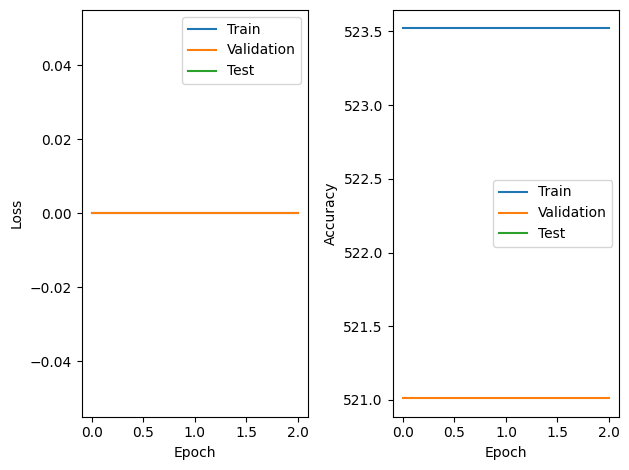

In [81]:
def plot_history(hist):
    plt.subplot(1,2,1)
    plt.plot(range(len(hist['train']['loss'])), hist['train']['loss'], label='Train')
    plt.plot(range(len(hist['validation']['loss'])), hist['validation']['loss'], label='Validation')
    plt.plot(range(len(hist['test']['loss'])), hist['test']['loss'], label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(len(hist['train']['acc'])), hist['train']['acc'], label='Train')
    plt.plot(range(len(hist['validation']['acc'])), hist['validation']['acc'], label='Validation')
    plt.plot(range(len(hist['test']['acc'])), hist['test']['acc'], label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
plot_history(hist)